Checking if the GPU is available, if so what is its model.

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  9 21:26:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Data Preprocessing

Importing Libraries:

In [20]:
from os import listdir
import os, glob,sys
from matplotlib import pyplot
from matplotlib.image import imread
import numpy as np
import random

Adding the paths

In [21]:
absolute_path = '/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/' 
dataset_path = '/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/'

In [22]:
folders = listdir(dataset_path)

# Function to count down the folders at the top level
def count_folders_in_folder(folder_path):
    folder_count = 0
    for root, dirs, files in os.walk(folder_path):
        folder_count += len(dirs)
        break  
    return folder_count


print(f"Number of folders in folder: {count_folders_in_folder(dataset_path)}")

Number of folders in folder: 21


Checking and taking one image as a sample

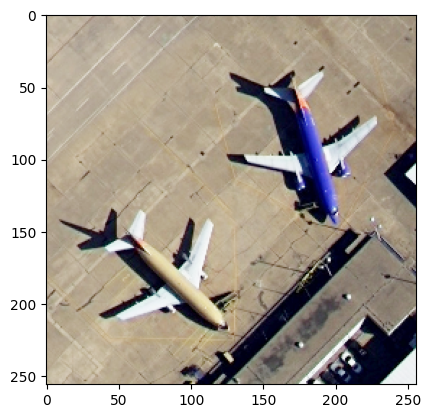

In [23]:
img_path = dataset_path + 'airplane/airplane23.tif'
image = imread(img_path)
pyplot.imshow(image)


Function to get real image dimension

In [24]:
from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    print ('Width: ', width, 'Height:', height)

get_num_pixels(img_path)

Width:  256 Height: 256


* Adjusting the image size
* Labeling the images
* Converting images to RGB 
* Performing data augmentation
* Performing pixel normalization
* Converting images to tensors
* Splitting them to train/validation/test sets as 0.7/0.15/0.15 ratio
* Creating dataloaders for the model


In [25]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Defining the class labels
class_labels = {
    'agricultural': 0,
    'airplane': 1,
    'baseballdiamond': 2,
    'beach': 3,
    'buildings': 4,
    'chaparral': 5,
    'denseresidential': 6,
    'forest': 7,
    'freeway': 8,
    'golfcourse': 9,
    'harbor': 10,
    'intersection': 11,
    'mediumresidential': 12,
    'mobilehomepark': 13,
    'overpass': 14,
    'parkinglot': 15,
    'river': 16,
    'runway': 17,
    'sparseresidential': 18,
    'storagetanks': 19,
    'tenniscourt': 20
}

# Custom dataset labeling and 
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Collecting image paths and labels, spliting each class'
train_image_paths, val_image_paths, test_image_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []

for class_name, label in class_labels.items():
    folder_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(folder_path):
        continue
    image_paths = [os.path.join(folder_path, img_name) for img_name in os.listdir(folder_path)]
    train_paths, temp_paths = train_test_split(image_paths, test_size=0.3, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)
    
    train_image_paths.extend(train_paths)
    val_image_paths.extend(val_paths)
    test_image_paths.extend(test_paths)
    train_labels.extend([label] * len(train_paths))
    val_labels.extend([label] * len(val_paths))
    test_labels.extend([label] * len(test_paths))

# Defining transformations
IMG_HEIGHT, IMG_WIDTH = 256, 256
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Creating dataset objects
train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=data_transforms['train'])
val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=data_transforms['val'])
test_dataset = CustomImageDataset(test_image_paths, test_labels, transform=data_transforms['test'])

# Creating DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


# Printing the counts
#for class_name, label in class_labels.items():
 #   print(f"{class_name}: {test_class_counts[label]}")




Checking if the data is balanced in the test set

agricultural: 15
airplane: 15
baseballdiamond: 15
beach: 15
buildings: 15
chaparral: 15
denseresidential: 15
forest: 15
freeway: 15
golfcourse: 15
harbor: 15
intersection: 15
mediumresidential: 15
mobilehomepark: 15
overpass: 15
parkinglot: 15
river: 15
runway: 15
sparseresidential: 15
storagetanks: 15
tenniscourt: 15


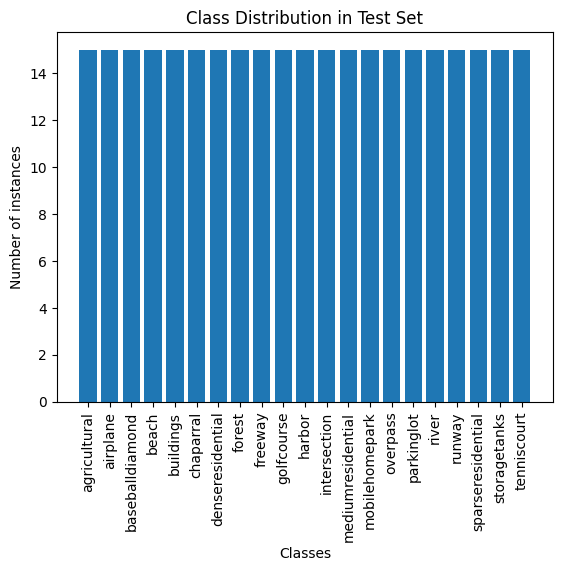

In [27]:
# Counting the number of instances for each class in the test set
test_class_counts = Counter([label for _, label in test_dataset])

# Printing the counts
for class_name, label in class_labels.items():
    print(f"{class_name}: {test_class_counts[label]}")

# Visualizing the distribution
plt.bar(class_labels.keys(), [test_class_counts[label] for label in class_labels.values()])
plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.xticks(rotation=90)
plt.title('Class Distribution in Test Set')
plt.show()


# Model

Resnet50 pretrained model is used, last 20 layers are unfreezed to make them trainable for my spesific dataset. First convolution layer is adjusted for my image sizes (256x256), last block's last convolution layer is adjusted for my task. Added fully connected head to this resnet model.

In [28]:
# Defining the model
model = models.resnet50(pretrained=True)


# Unfreezing the last 20 layers for fine-tuning
for name, param in list(model.named_parameters())[:-20]:
    param.requires_grad = False

# Access the last bottleneck block in layer4
last_block = model.layer4[-1]

# Modify the conv2 layer in the last bottleneck block
last_block.conv2 = nn.Sequential(
    nn.Conv2d(last_block.conv2.in_channels, last_block.conv2.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(last_block.conv2.out_channels),
    nn.ReLU(inplace=True)
)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_labels))
)  # The final layer is the number of classes

# Adjust the first convolutional layer if needed (for input size 256x256)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 


Model Summary:

In [29]:
# Print model summary
summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# Training and Validation

Criterion is selected as cross entropy loss since it is an image classifier, optimizer is changed to SGD since it is more suitible when working with images. Patience is 5, the model is gonna stop before finishing the epoch numbers if the loss doesn't decrease for 5 epoch (early stopping). Best model is saved.

In [30]:
# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training loop

# Early stopping configuration
patience = 5
num_epochs = 50
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)

train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / train_size
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
    
    val_loss = val_loss / val_size
    val_losses.append(val_loss)
    val_acc = corrects.double() / val_size
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    
    # Early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss*0.999:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Saving the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Loss: 3.0090
Validation Loss: 2.9742, Accuracy: 0.1714
Epoch 2/50, Loss: 2.4969
Validation Loss: 2.6694, Accuracy: 0.1810
Epoch 3/50, Loss: 2.1252
Validation Loss: 2.0337, Accuracy: 0.5270
Epoch 4/50, Loss: 1.8343
Validation Loss: 1.6240, Accuracy: 0.6825
Epoch 5/50, Loss: 1.6476
Validation Loss: 1.4147, Accuracy: 0.6762
Epoch 6/50, Loss: 1.4508
Validation Loss: 1.3234, Accuracy: 0.7365
Epoch 7/50, Loss: 1.3185
Validation Loss: 1.1096, Accuracy: 0.8032
Epoch 8/50, Loss: 1.1862
Validation Loss: 1.0773, Accuracy: 0.7810
Epoch 9/50, Loss: 1.0763
Validation Loss: 0.9607, Accuracy: 0.8349
Epoch 10/50, Loss: 0.9772
Validation Loss: 0.9152, Accuracy: 0.8190
Epoch 11/50, Loss: 0.8758
Validation Loss: 0.7854, Accuracy: 0.8698
Epoch 12/50, Loss: 0.7817
Validation Loss: 0.6904, Accuracy: 0.8794
Epoch 13/50, Loss: 0.7248
Validation Loss: 0.6535, Accuracy: 0.8952
Epoch 14/50, Loss: 0.6283
Validation Loss: 0.5945, Accuracy: 0.8794
Epoch 15/50, Loss: 0.5510
Validation Loss: 0.5549, Accura

<All keys matched successfully>

 Epoch-loss graph is printed.

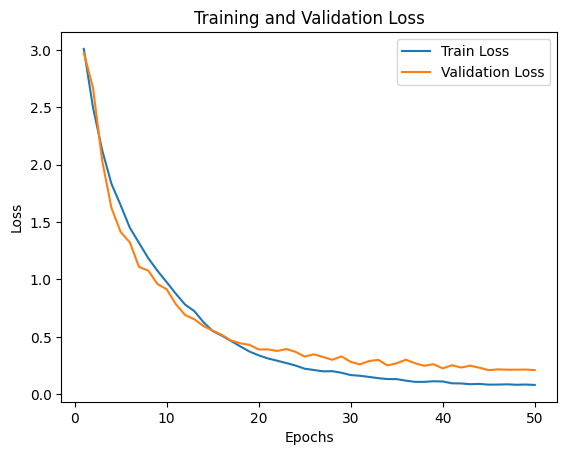

In [31]:
# Plotting epoch loss graph
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

Model is tested with test data.

In [32]:
# Testing loop
model.eval()
test_loss = 0.0
corrects = 0
test_predictions = []
test_probabilities = []
test_images = []
test_labels_collected = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)
        
        corrects += torch.sum(preds == labels.data)
        
        test_predictions.extend(preds.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        test_images.extend(images.cpu().numpy())
        test_labels_collected.extend(labels.cpu().numpy())

test_loss = test_loss / test_size
test_acc = corrects.double() / test_size
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Test Loss: 0.2518, Accuracy: 0.9206


Some images are visualized and classes are predicted for them,
and also predictions' probabilites are shown.

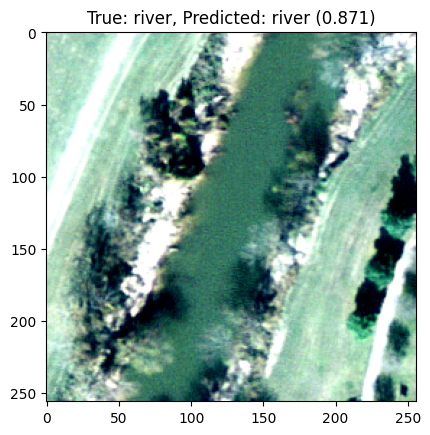

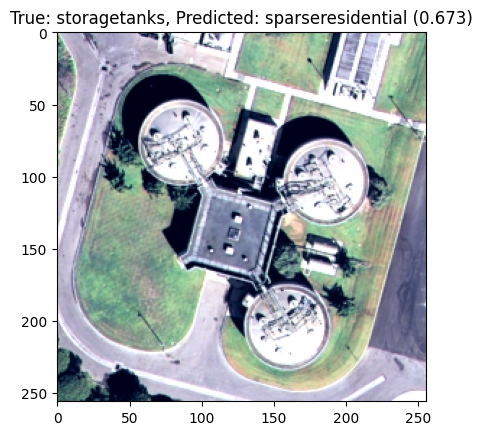

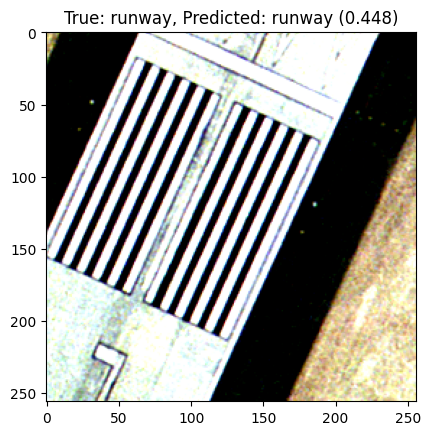

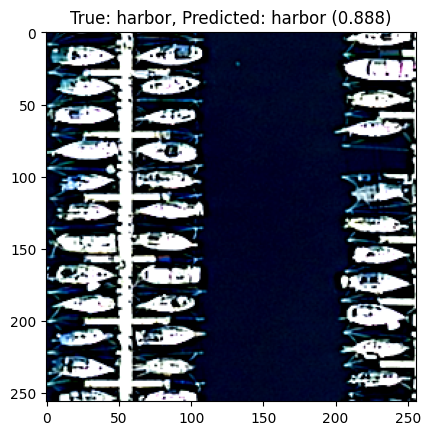

In [33]:
# Visualizing some images with predictions and probabilities
def imshow(image, title):
    image = image / 2 + 0.5  # unnormalizing (according to mean and std)
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


num_images_to_show = 4
for i in range(num_images_to_show):
    image = test_images[i]
    label = test_labels_collected[i]
    prediction = test_predictions[i]
    probability = test_probabilities[i][prediction]
    imshow(torch.tensor(image), title=f'True: {list(class_labels.keys())[label]}, Predicted: {list(class_labels.keys())[prediction]} ({probability:.3f})')

## ROC and AUC
The model's performance is quantified by calculating the ROC curve (true positive rate vs false positive rate for each value of a sliding cut on the network predictions) and Area Under Curve (AUC).

The ideal ROC curve would be a rectangular with true positives fraction=1 and false positive fraction= 0 and the AUC is 1.


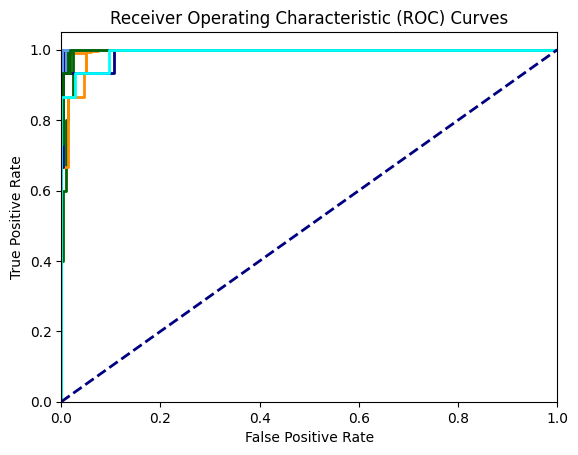

In [37]:
# ROC-AUC curves
# Binarize the labels for multi-class ROC-AUC
num_classes = len(class_labels)
y_test_binarized = label_binarize(test_labels_collected, classes=[i for i in range(num_classes)])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], np.array(test_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), np.array(test_probabilities).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='micro-average ROC curve (area = {0:0.2f})'
                      ''.format(roc_auc["micro"]))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'darkgreen'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.show()


## Confusion matrix

Shows (true positive / true negative / false positive / false negative) rates in a 2x2 matrix.

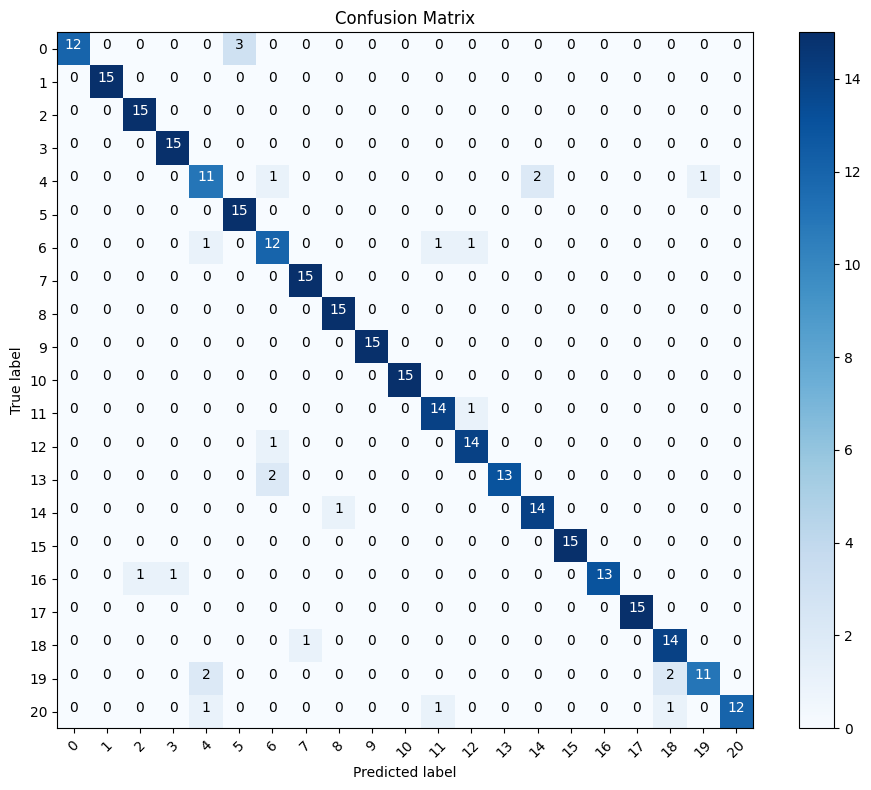

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_collected, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels.values(), rotation=45)
plt.yticks(tick_marks, class_labels.values())

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Filters visualization

Some convolution filters are visualized and by getting weights for filters.

Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Weight shape: (64, 3, 7, 7)
Filter 0 - min: -0.08305788040161133, max: 0.0736677348613739
Filter 1 - min: -0.08817559480667114, max: 0.08556060492992401
Filter 2 - min: -0.08679807186126709, max: 0.08111166954040527
Filter 3 - min: -0.08134777098894119, max: 0.07769077271223068
Filter 4 - min: -0.08594170957803726, max: 0.08695808798074722
Filter 5 - min: -0.08655013144016266, max: 0.0843125730752945
Filter 6 - min: -0.07742477208375931, max: 0.09134941548109055
Filter 7 - min: -0.09012187272310257, max: 0.07698459923267365


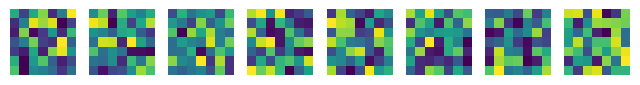

In [39]:
# Function to visualize filters of a convolutional layer
def visualize_filters(layer, num_filters=8):
    if isinstance(layer, nn.Conv2d):
        weights = layer.weight.data.cpu().numpy()
        print(f"Layer: {layer}")
        print(f"Weight shape: {weights.shape}")
        fig, axes = plt.subplots(1, num_filters, figsize=(num_filters, 1))
        for i in range(num_filters):
            filter = weights[i, 0, :, :]
            print(f"Filter {i} - min: {filter.min()}, max: {filter.max()}")
            if filter.max() != filter.min():  # Check to avoid division by zero
                filter = (filter - filter.min()) / (filter.max() - filter.min())  # Normalize filter to [0, 1]
            filter = (filter * 255).astype(np.uint8)  # Scale to [0, 255]
            axes[i].imshow(filter, cmap='viridis')
            axes[i].axis('off')
        plt.show()

# Visualize filters of the first convolutional layer
visualize_filters(model.conv1, num_filters=8)




The dark squares indicate small  weights and the light squares represent large weights.

## Features visualization

Some features are visualized by applying filters to input images. They can give an insight information from the internal representation. (what is going on inside of this black box!) (explainable ai XAI)

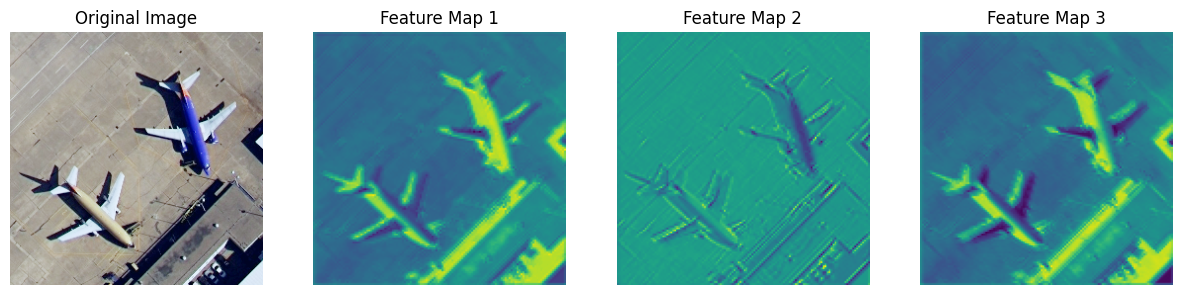

In [40]:
# Defining a function to get the intermediate layers of the model
def get_feature_maps(model, layers, x):
    feature_maps = []
    hooks = []

    def hook_fn(module, input, output):
        feature_maps.append(output)

    for layer in layers:
        hooks.append(layer.register_forward_hook(hook_fn))

    model(x)

    for hook in hooks:
        hook.remove()

    return feature_maps

# Defining the layers you want to extract feature maps from
layers = [
    model.conv1,
    model.layer1[0].conv1,
    model.layer1[0].conv2,
    model.layer1[0].conv3,
    model.layer2[0].conv1,
    model.layer2[0].conv2,
    model.layer2[0].conv3,
    model.layer3[0].conv1,
    model.layer3[0].conv2,
    model.layer3[0].conv3,
    model.layer4[0].conv1,
    model.layer4[0].conv2,
    model.layer4[0].conv3,
    model.layer4[1].conv1,
    model.layer4[1].conv2,
    model.layer4[1].conv3,
    model.layer4[2].conv1,
    model.layer4[2].conv2,
    model.layer4[2].conv3,
]

# Defining a function to preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to plot feature maps with the original image
def plot_feature_maps_with_image(original_image, feature_maps, num_features=3):
    original_image = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())  # Normalize to [0, 1]
    
    fig, axes = plt.subplots(1, num_features + 1, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(num_features):
        feature_map = feature_maps[0].squeeze(0)[i].cpu().detach().numpy()
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize to [0, 1]
        axes[i + 1].imshow(feature_map, cmap='viridis')
        axes[i + 1].set_title(f'Feature Map {i+1}')
        axes[i + 1].axis('off')

    plt.show()

# Loading and preprocessing the image
image_path = img_path
input_image = preprocess_image(image_path).to(device)

# Geting the feature maps from the intermediate layers
model.eval()
with torch.no_grad():
    feature_maps = get_feature_maps(model, layers, input_image)

# Plotting the original image and the feature maps
plot_feature_maps_with_image(input_image, feature_maps, num_features=3)
